<a href="https://colab.research.google.com/github/tomasrtml/pytorch-deep-learning/blob/main/Proyecto_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install git

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git is already the newest version (1:2.25.1-1ubuntu3.10).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [2]:
!git config --global user.email "tomasretamalvenegas@gmail.com"
!git config --global user.name "tomasrtml"

In [4]:
!mkdir prueba

In [8]:
!git status

On branch master

No commits yet

nothing to commit (create/copy files and use "git add" to track)


In [16]:
ls -l

total 55504
-rwxr-xr-x 1 root root     1697 Jan  1  2000 anscombe.json*
-rw-r--r-- 1 root root   301141 Apr  7 13:30 california_housing_test.csv
-rw-r--r-- 1 root root  1706430 Apr  7 13:30 california_housing_train.csv
-rw-r--r-- 1 root root 18289443 Apr  7 13:30 mnist_test.csv
-rw-r--r-- 1 root root 36523880 Apr  7 13:30 mnist_train_small.csv
-rwxr-xr-x 1 root root      930 Jan  1  2000 README.md*


In [6]:
!git init

Initialized empty Git repository in /content/prueba/.git/


In [7]:
!git add

Nothing specified, nothing added.
Maybe you wanted to say 'git add .'?


In [ ]:
import torch
import torchvision
device = "cuda" if torch.cuda.is_available() else "cpu"
# Note: Required to have PyTorch > 1.11.0 & torchvision > 0.12.0 for Food101 dataset
#assert int(torch.__version__.split(".")[1]) >= 11
#assert int(torchvision.__version__.split(".")[1]) >= 11

import torchvision.datasets as datasets
import torchvision.transforms as transforms

# Setup data directory
import pathlib
data_dir = pathlib.Path("../data")

In [ ]:
# Get training data
train_data = datasets.MNIST(root=data_dir,
                              train=True,
                              transform=transforms.ToTensor(),
                              download=True)

# Get testing data
test_data = datasets.MNIST(root=data_dir,
                             train=False,
                             transform=transforms.ToTensor(),
                             download=True)

In [ ]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=100, # how many samples per batch?
                               shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=100, 
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f5b0d3daf40>,
 <torch.utils.data.dataloader.DataLoader at 0x7f5b0b316df0>)

In [ ]:
from torch import nn
class LinealModel(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.secuencia = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = input_shape,
                  out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units,
                  out_features = output_shape)
    )
  def forward(self, x):
    return self.secuencia(x)
    
torch.manual_seed(42)
modelo_lineal = LinealModel(
    input_shape = 28*28,
    hidden_units = 500,
    output_shape = 10
).to(device)

modelo_lineal

LinealModel(
  (secuencia): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=500, bias=True)
    (2): ReLU()
    (3): Linear(in_features=500, out_features=10, bias=True)
  )
)

In [ ]:
# from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=modelo_lineal.parameters(), 
                            lr=0.001)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [ ]:
from timeit import default_timer as timer 
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [ ]:
from timeit import default_timer as timer 
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epochs (we'll keep this small for faster training times)
epochs = 5
train_losses = []
test_losses  = []
test_accs     = []

# Create training and testing loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    ### Training
    train_loss = 0
    # Add a loop to loop through training batches
    for batch, (X, y) in enumerate(train_dataloader):
        # en cada iteración, X es un tensor con las siguientes dimensiones:
        # [batch size, canales de color, pixeles altura, pixeles ancho];
        # es decir, X es un gran tensor que contiene todas las imágenes de cada batch
        X = X.to(device)
        # y, en cambio, es un vector de tamaño 'batch size' que contiene los labels
        # de cada uno de los (en este caso) 32 tensores dentro de X
        y = y.to(device)
        modelo_lineal.train() 
        # 1. Forward pass
        y_logits = modelo_lineal(X)
        #print(type(y_logits))
        y_pred = torch.softmax(y_logits, dim=1)#.argmax(dim=1)
        #print(type(y_pred))

        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulatively add up the loss per epoch 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Print out how many samples have been seen
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_dataloader)
    train_losses.append(train_loss.to('cpu').detach().numpy())
    
    ### Testing
    # Setup variables for accumulatively adding up loss and accuracy 
    test_loss, test_acc = 0, 0 
    modelo_lineal.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            X = X.to(device)
            y = y.to(device)
            # 1. Forward pass
            test_pred = modelo_lineal(X)
           
            # 2. Calculate loss (accumatively)
            test_loss += loss_fn(test_pred, y) # accumulatively add up the loss per epoch

            # 3. Calculate accuracy (preds need to be same as y_true)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
        
        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_dataloader)

        test_losses.append(test_loss.to('cpu').detach().numpy())
        test_accs.append(test_acc)

    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

# Calculate training time      
train_time_end_on_cpu = timer()
total_train_time_modelo_lineal = print_train_time(start=train_time_start_on_cpu, 
                                           end=train_time_end_on_cpu,
                                           device=str(next(modelo_lineal.parameters()).device))

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/60000 samples
Looked at 40000/60000 samples

Train loss: 1.58415 | Test loss: 0.31067, Test acc: 93.48%

Epoch: 1
-------
Looked at 0/60000 samples
Looked at 40000/60000 samples

Train loss: 1.51782 | Test loss: 0.21390, Test acc: 95.76%

Epoch: 2
-------
Looked at 0/60000 samples
Looked at 40000/60000 samples

Train loss: 1.50339 | Test loss: 0.16594, Test acc: 96.50%

Epoch: 3
-------
Looked at 0/60000 samples
Looked at 40000/60000 samples

Train loss: 1.49364 | Test loss: 0.14903, Test acc: 97.15%

Epoch: 4
-------
Looked at 0/60000 samples
Looked at 40000/60000 samples

Train loss: 1.48802 | Test loss: 0.13960, Test acc: 97.42%

Train time on cuda:0: 49.136 seconds


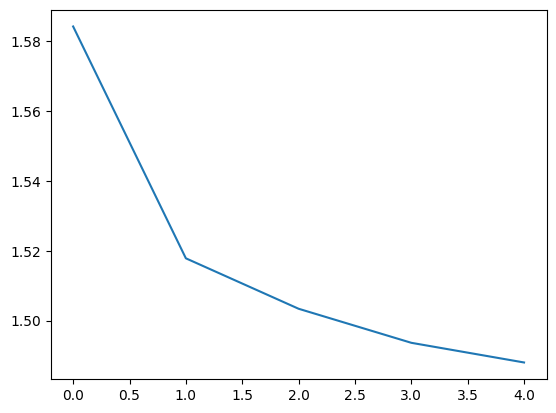

In [ ]:
#losses[0].to('cpu').detach().numpy()
plt.plot(train_losses)

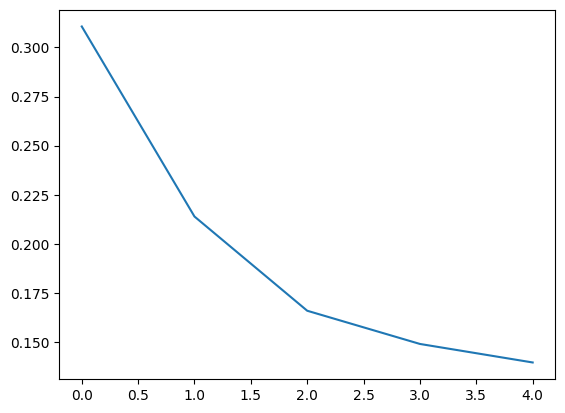

In [ ]:
plt.plot(test_losses)

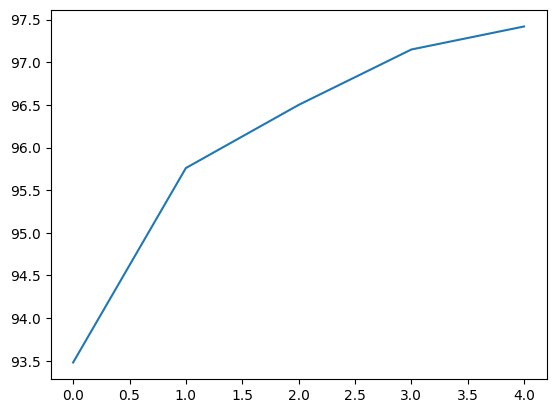

In [ ]:
plt.plot(test_accs)

# Graficando

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import random

def plot_tensors_from_dataloader(dataloader, num_tensors=4):
    # Obtener tensores aleatorios del DataLoader
    tensors = []
    labels = []
    for i, data in enumerate(dataloader):
        if i == num_tensors:
            break
        numero = random.randint(1,50)
        tensors.append(data[0][numero])
        labels.append(data[1][numero])

    # Graficar los tensores en una cuadrícula
    fig, axes = plt.subplots(4, 2, figsize=(10, 10))

    for i, tensor in enumerate(tensors):
        modelo_lineal.eval()
        with torch.inference_mode():
            logits = modelo_lineal(tensor.to(device))
            probs  = torch.softmax(logits, dim = 1)
            pred   = probs.argmax()

        # Obtener imagen del tensor y convertirla a NumPy
        img = tensor.permute(1, 2, 0).numpy()
        label = labels[i]
        axes[i, 0].imshow(img, cmap = 'Reds' if pred != label else 'gray')
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f'Label: {label} | Pred: {pred}', color = "red" if pred != label else "black")
        axes[i, 1].bar(range(10), probs.squeeze().tolist())
        axes[i, 1].set_xticks(range(10))
        axes[i, 1].set_title(f'Probabilidades de cada clase', color = "red" if pred != label else "black")

    plt.subplots_adjust(hspace=0.5, wspace=0.1)
    plt.show()

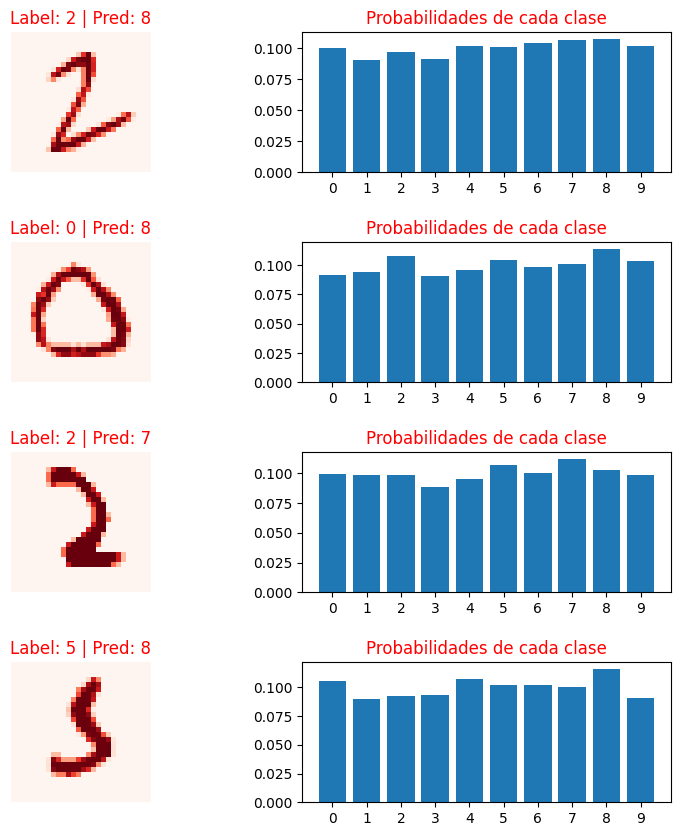

In [ ]:
plot_tensors_from_dataloader(test_dataloader)

# Mis imágenes

In [ ]:
from PIL import Image
lista_tres = [Image.open(f'../data/{letra}_tres_mio.png') for letra in ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']]
t = transforms.ToTensor()
lista_tres_tensores_un_canal = [t(imagen)[0,:,:].unsqueeze(dim=2) for imagen in lista_tres]
lista_tres_tensores_un_canal_numpy = [tensor.numpy() for tensor in lista_tres_tensores_un_canal]

In [ ]:
xe = lista_tres_tensores_un_canal[0].permute(2,0,1)#.size()
modelo_lineal.eval()
with torch.inference_mode():
  logits = modelo_lineal(xe.to(device))
  probs  = torch.softmax(logits, dim = 1)
  pred   = probs.argmax()
pred

tensor(2)

In [ ]:
xe.size()

torch.Size([1, 28, 28])

RuntimeError: ignored

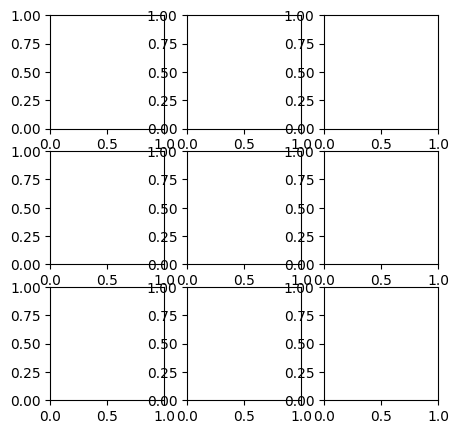

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(5, 5))

for row in range(3):
  for column in range(3):
    i = 2 * row + row + column
    modelo_lineal.eval()
    with torch.inference_mode():
      logits = modelo_lineal(lista_tres_tensores_un_canal[i].to(device))
      probs  = torch.softmax(logits, dim = 1)
      pred   = probs.argmax()
    img = lista_tres_tensores[i]
    axes[row, column].imshow(img, cmap = 'gray')

    # Obtener imagen del tensor y convertirla a NumPy
    
    #label = 1
# Graficar imagen en la subfigura correspondiente
#print(pred, label)
#axes.imshow(img, cmap = 'Reds')# if pred != label else 'Reds')
#axes.set_title(f'Label: {label} | Pred: {pred}', color = "red" if pred != label else "black")
#else:
#    axes[row_idx, col_idx].imshow(img, cmap = 'Reds' if pred != label else 'gray')
#    axes[row_idx, col_idx].set_title(f'Label: {label} | Pred: {pred}', color = "red" if pred != label else "black")
#plt.show()

In [ ]:
next(iter(train_dataloader))[0][0].size()

torch.Size([1, 28, 28])

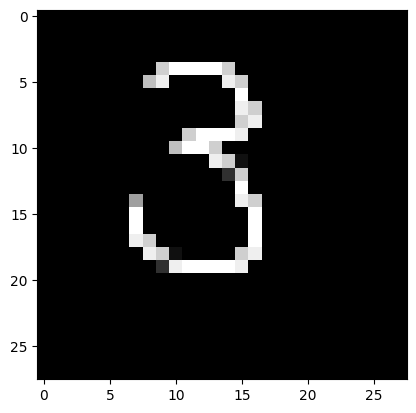

In [ ]:
#lista_tres_tensores[0][0,:,:].unsqueeze(dim=2).size()
plt.imshow(lista_tres_tensores[0][2,:,:].unsqueeze(dim=2).numpy(), cmap='gray')
plt.show()